### Vector functions to calculate and analyse effective fetch 

<b>fetch_lines</b> -    Creates fetch lines SHP from SHP or gdb feature class of points (with int field PID with unique value) inside polygon SHP or gdb feature class  for defined wind directions.
Result  atribute table firlds are: PID - point ID; lff - wind direction; nrfl - number of radial line (clockwise) and SHPL - length of fetch segment.

<b>effetch_csv</b> - calculate csv file with effective fetch in points (PID) for all wind directions

<b>stat_effetch_csv</b> - calculate csv file with mean effective fetch in points PID, with fields,
                    WAFETCH  - weighted (by wind direction frequancy) average effective featch, 
                    MXFETCH - maximum fetch (for all wind direction),
                    MFFEATCH - fetch in the most frequent wind direction,
                    REI - relative wave exposure indices (optional) 
<br><br>
Effective fetch definition
<br><br>
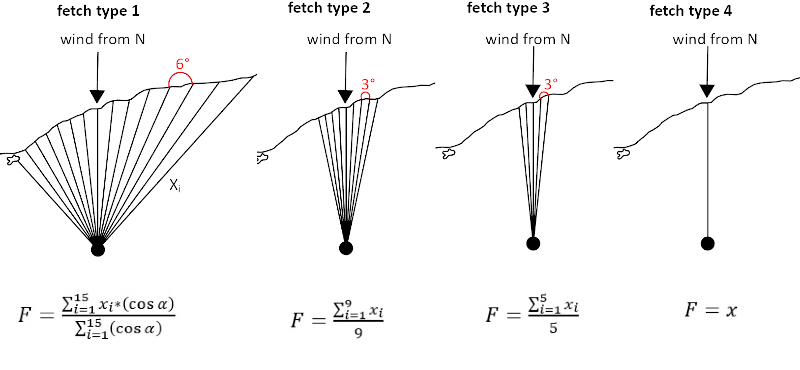

In [1]:
#Application dependencies 

from osgeo import ogr, osr
import math
import numpy as np
import os

In [2]:
# Internal functions of vector wind fetch calculation

def extract_folder(full_path):
    folder_path = os.path.dirname(full_path)
    return folder_path

def get_file_extension(file_path):
    _, extension = os.path.splitext(file_path)
    return extension.lower()

def get_file_name_without_extension(file_path): 
    directory = os.path.dirname(file_path)  # Extracts the directory path
    base_name = os.path.basename(file_path)  # Extracts the base name from the file path
    file_name_without_extension, _ = os.path.splitext(base_name)  # Splits the base name into name and extension
    return os.path.join(directory, file_name_without_extension)

def delete_shapefile(shapefile_path):
    # Check if the shapefile exists
    if not os.path.exists(shapefile_path):
        #print(f"Shapefile '{shapefile_path}' does not exist.")
        ds_err=20
        return 0,20
    
    # Delete the shapefile
    try:
        # Remove all associated files (.shp, .shx, .dbf, etc.)
        for extension in ['.shp', '.shx', '.dbf', '.prj', '.cpg', '.sbn', '.sbx', '.fbn', '.fbx', '.ain', '.aih', '.ixs', '.mxs', '.atx', '.shp.xml', '.qix']:
            file_path = shapefile_path.replace('.shp', extension)
            if os.path.exists(file_path):
                os.remove(file_path)
        #print(f"Shapefile '{shapefile_path}' deleted successfully.")
    except Exception as e:
        toolER=4
        #print(f"Failed to delete shapefile '{shapefile_path}': {str(e)}")

def get_unique_sorted_values(shp_file, field_name):
    # Open the shapefile
    driver = ogr.GetDriverByName('ESRI Shapefile')
    datasource = driver.Open(shp_file, 0)
    
    if datasource is None:
        print("Could not open", shp_file)
        return None
    
    layer = datasource.GetLayer()
    field_index = layer.GetLayerDefn().GetFieldIndex(field_name)
    
    if field_index < 0:
        print("Field not found:", field_name)
        return None
    
    unique_values = set()
    
    # Iterate through features to collect unique values
    for feature in layer:
        field_value = feature.GetField(field_index)
        if field_value is not None:
            unique_values.add(field_value)
    
    # Close the shapefile
    datasource = None
    
    # Convert set to list and sort
    unique_sorted_values = sorted(list(unique_values))
    
    return unique_sorted_values
        
        
def clip_lines_by_polygons(lines_shp, clip_, result_shp):
    # Open the input line shapefile
    lines_ds = ogr.Open(lines_shp)
    if lines_ds is None:
        toolER=5
        print("Could not open input line shapefile in cl_by_p.")
        return 

    # Get the input line layer
    lines_layer = lines_ds.GetLayer()

    path1,name1=extract_gdb_or_gpkg_path_and_layer(clip_)
    if name1=='SHP':
        clip_ds = ogr.Open(clip_, 0)
        if clip_ds is None:
                toolER=6
                #print("Failed to open polygon shapefile in cl_by_p.") 
                return
        clip_layer = clip_ds.GetLayer()
    else:
        filegdb = ogr.Open(path1)
        if filegdb is None:
            toolER=1
            #print("Failed to open the geodatabase")
            return None
        clip_layer = filegdb.GetLayerByName(name1)

    # Create the output shapefile
    driver = ogr.GetDriverByName("ESRI Shapefile")
    result_ds = driver.CreateDataSource(result_shp)
    if result_ds is None:
        toolER=7
        #print("Could not create output shapefile in cl_by_p.")
        return

    # Create the output layer
    result_layer = result_ds.CreateLayer("clipped", geom_type=ogr.wkbLineString)
    if result_layer is None:
        toolER=8
        #print("Could not create output layer in cl_by_p.")
        return

    # Copy fields from input line layer to output layer
    lines_defn = lines_layer.GetLayerDefn()
    for i in range(lines_defn.GetFieldCount()):
        field_defn = lines_defn.GetFieldDefn(i)
        result_layer.CreateField(field_defn)

    # Iterate through features in the clip layer
    licznik=0
    sumlicznik= lines_layer.GetFeatureCount()
    for clip_feature in clip_layer:
 
        clip_geometry = clip_feature.GetGeometryRef()

        # Set spatial filter for the input line layer based on the clip feature
        lines_layer.SetSpatialFilter(clip_geometry)

        # Iterate through features in the input line layer
        suma=0
        krok=sumlicznik/10
        for line_feature in lines_layer:
            licznik+=1
            if licznik>=krok:
                print('.',end=' ')
                licznik=0
            
            
            line_geometry = line_feature.GetGeometryRef()

            # Perform intersection to clip the line feature by the polygon feature
            clipped_geometry = line_geometry.Intersection(clip_geometry)

            # If there's a valid intersection, create a new feature in the output layer
            if clipped_geometry:
                out_feature = ogr.Feature(result_layer.GetLayerDefn())
                out_feature.SetGeometry(clipped_geometry)

                # Copy attribute values from input line feature to output feature
                for i in range(lines_defn.GetFieldCount()):
                    field_name = lines_defn.GetFieldDefn(i).GetName()
                    out_feature.SetField(field_name, line_feature.GetField(i))

                # Add the feature to the output layer
                result_layer.CreateFeature(out_feature)
                out_feature = None
    print()
    # Cleanup
    lines_ds = None
    clip_ds = None
    result_ds = None



def explode_multi_to_single(input_file, output_file):
    # Open the input file
    input_ds = ogr.Open(input_file)
    if input_ds is None:
        toolER=9
        #print("Could not open input file in ex_m_s.")
        return

    # Create output file
    driver = ogr.GetDriverByName('ESRI Shapefile')
    output_ds = driver.CreateDataSource(output_file)
    if output_ds is None:
        toolER=10
        #print("Could not create output file in ex_m_s.")
        return

    # Loop through each layer in the input dataset
    for i in range(input_ds.GetLayerCount()):
        layer = input_ds.GetLayerByIndex(i)
        layer_defn = layer.GetLayerDefn()

        # Create a new layer in the output dataset
        output_layer = output_ds.CreateLayer(layer_defn.GetName(), geom_type=layer_defn.GetGeomType())

        # Copy fields from input layer to output layer
        for j in range(layer_defn.GetFieldCount()):
            field_defn = layer_defn.GetFieldDefn(j)
            output_layer.CreateField(field_defn)
            
        licznik=0
        sumlicznik= layer.GetFeatureCount()
        suma=0
        krok=sumlicznik/10
        # Loop through features in the input layer
        for feature in layer:
            licznik+=1
            if licznik>=krok:
                print('.',end=' ')
                licznik=0
            geom = feature.GetGeometryRef()
           
            # If the geometry is a multi-line string, explode it into single parts
            if geom.GetGeometryType() == ogr.wkbMultiLineString:
                for i in range(geom.GetGeometryCount()):
                    new_feature = ogr.Feature(layer_defn)
                    new_feature.SetGeometry(geom.GetGeometryRef(i))
                    for j in range(layer_defn.GetFieldCount()):
                        new_feature.SetField(layer_defn.GetFieldDefn(j).GetNameRef(), feature.GetField(j))
                    output_layer.CreateFeature(new_feature)
                    new_feature = None
            else:
                output_layer.CreateFeature(feature)

    # Close datasets
    input_ds = None
    output_ds = None
    print()

def select_lines_with_zero_distance_to_points(lines_shp, points_, result_lines_shp):

    lines_ds = ogr.Open(lines_shp, 0)
    if lines_ds is None:
        toolER=11
        #print("Failed to open lines shapefile in sl_d.")
        return
    
    # Open the points shapefile

    path1,name1=extract_gdb_or_gpkg_path_and_layer(points_)
    #print(path1,name1)
    if name1=='SHP':
        points_ds = ogr.Open(points_, 0)
        if points_ds is None:
                toolER=12
                #print("Failed to open points shapefile in featch_lines.")    
        points_layer = points_ds.GetLayer()
    else:
        filegdb = ogr.Open(path1)

        if filegdb is None:
            toolER=1
            #print("Failed to open the geodatabase")
            return None

        # Get the layer by name
        points_layer = filegdb.GetLayerByName(name1)
    pidflag=0
    if points_layer is None:
        toolER=2
        #print("Layer not found")
   

    
    # Create a new shapefile to store the result
    driver = ogr.GetDriverByName('ESRI Shapefile')
    result_ds = driver.CreateDataSource(result_lines_shp)
    result_layer = result_ds.CreateLayer('result', geom_type=ogr.wkbLineString)
    

    
    # Copy the fields from the original lines shapefile to the result shapefile
    lines_layer = lines_ds.GetLayer()
    #points_layer = points_ds.GetLayer()
    
    
    for i in range(lines_layer.GetLayerDefn().GetFieldCount()):
        field_defn = lines_layer.GetLayerDefn().GetFieldDefn(i)
        result_layer.CreateField(field_defn)
    nrl=0
    
    # Define field "SHPL" for the length of the lines
    shpl_field = ogr.FieldDefn("SHPL", ogr.OFTReal)
    result_layer.CreateField(shpl_field)
    
    # Loop through each line
    licznik=0
    sumlicznik= lines_layer.GetFeatureCount()
    suma=0
    krok=sumlicznik/10
    ii=0
    for line_feature in lines_layer:
       
        licznik+=1
        if licznik>=krok:
            print('.',end=' ')
            licznik=0
         # Calculate the length of the line
        pline=lines_layer.GetFeature(ii)    
        IDline=pline.GetFieldAsInteger('PID')
        ii+=1
        #print(IDline)
        line_geom = line_feature.GetGeometryRef()
        line_length = line_geom.Length()
        
        #print(line_length)
        zero_distance_found = False
        
        if name1=='SHP':
            jj=0
        else:
            jj=1
        for point_feature in points_layer:
            point_geom=point_feature.GetGeometryRef()
            ppoint=points_layer.GetFeature(jj)
            IDpoint=ppoint.GetFieldAsInteger('PID')
            jj+=1
            #print(IDpoint)
            dyst=line_geom.Distance(point_geom)
  
            if line_geom.Distance(point_geom) < 1 and IDline==IDpoint:
                    zero_distance_found = True
                    break                
            # If zero distance is found, add the line to the result layer
        if zero_distance_found:
            result_feature = ogr.Feature(result_layer.GetLayerDefn())
            result_feature.SetGeometry(line_geom.Clone())
            #print(line_length)

            for i in range(line_feature.GetFieldCount()):
                result_feature.SetField(i, line_feature.GetField(i))              
            result_layer.CreateFeature(result_feature)
            result_feature.SetField("SHPL", line_length) 
            result_layer.SetFeature(result_feature)

            result_feature = None


                
                
    # Close all the shapefiles
    lines_ds = None
    points_ds = None
    result_ds = None
    print('.',end=' ')
    print()
def extract_gdb_or_gpkg_path_and_layer(file_path):
    def is_shapefile(file_path):
        _, file_extension = os.path.splitext(file_path)
        return file_extension.lower() == '.shp'
    if is_shapefile(file_path):
        return file_path, 'SHP'
    else:
    # Split the path into components
        path_components = file_path.split(os.sep)

        # Initialize variables to store GDB/GPKG path and layer name
        gdb_gpkg_path = None
        layer_name = None

        # Iterate over each component to find the one containing ".gdb" or ".gpkg"
        gdb_gpkg_index = None
        for i, component in enumerate(path_components):
            if ".gdb" in component.lower() or ".gpkg" in component.lower():
                gdb_gpkg_index = i
                break

        # If a ".gdb" or ".gpkg" component is found, construct the path up to that component
        if gdb_gpkg_index is not None:
            gdb_gpkg_path = os.sep.join(path_components[:gdb_gpkg_index + 1])

            # Check if there are remaining components for layer name
            if gdb_gpkg_index + 1 < len(path_components):
                layer_name = os.sep.join(path_components[gdb_gpkg_index + 1:])

        return gdb_gpkg_path, layer_name    
''' 
--------------------------------------------------------------------------------------------------------------------------------------
-------------------------------- MAIN  FUNCTIONS --------------------------------------------------------------------------------------    

fetch_lines - create fetch lines from points inside polygon(s)

effetch_csv - create text file with effective fetch for all wind direction (for all points)

stat_effetch_csv - create text file with weigted mean fetch, maximum fetch, relative wave exposure indices (optional)

'''
def fetch_lines(points_ : str, lake : str, fetchtype : int, dff : list, dd : float, result : str,
                start: int, end : int, deltafi : float=None):
    '''
    Creates fetch lines SHP from SHP of points (with int field PID with unique value) inside polygon SHP  for defined wind directions.
    Atribute table firlds are: PID - point ID; lff - wind direction; nrfl - number of radial line (clockwise) and 
    SHPL - length of fetch segment. 
    
    Parameters
    ---------------------------------------------
    points: string
        path with name of point feature SHP inside polygon with field PID (int) with nambers of points (1,2,3......)
    lake: string
        path with name of polygon SHP
    fetchtype : integer
        type of fetch (1,2,3,4) 
    dff: list
        list of wind directions
    dd: max length of fetvh lines [m]
    result: string
        path with name of fetch lines SHP
    start: int
        start point ID
    end: int
        end point ID
    deltafi: float
       (optional)  wind direction correction  (when  ax y is not in N-S direction)
    
    '''
    #print('Parameters main')
    #print(points_)
    #print(lake)
    #print(result)
    
    global toolER
    def open_layer_from_geodatabase(filegdb_path, layer_name):
        global toolER
        # Open the FileGDB
        filegdb = ogr.Open(filegdb_path)

        if filegdb is None:
            #print("Failed to open the geodatabase")
            toolER=1
            return None

        # Get the layer by name
        layer = filegdb.GetLayerByName(layer_name)

        if layer is None:
            #print("Layer not found")
            toolER=2
            return None

        return layer
    def ddfipoint_eff(x0: float, y0: float, dd: float, fi: float, deltafi: float=0):
            for i in range (0,15):
                lfi = fi + (i-7)*6+deltafi
                if (lfi >= 360):
                    lfi = lfi - 360
                radlfi = math.radians(lfi)
                xdd = math.sin(radlfi)*dd+x0
                ydd = math.cos(radlfi)*dd+y0
                xy_fetch[i,0] = lfi
                xy_fetch[i,1] = xdd
                xy_fetch[i,2] = ydd
            return 1
    def ddfipoint_SPM(x0: float, y0: float, dd: float, fi: float, deltafi: float=0):
            for i in range (0,9):
                lfi = fi + (i-4)*3+deltafi
                if (lfi >= 360):
                    lfi = lfi - 360
                radlfi = math.radians(lfi)
                xdd = math.sin(radlfi)*dd+x0
                ydd = math.cos(radlfi)*dd+y0
                xy_fetch[i,0] = lfi
                xy_fetch[i,1] = xdd
                xy_fetch[i,2] = ydd
            return 1
    def ddfipoint_SPMR(x0: float, y0: float, dd: float, fi: float, deltafi: float=0):
            for i in range (0,5):
                lfi = fi + (i-2)*3+deltafi
                if (lfi >= 360):
                    lfi = lfi - 360
                radlfi = math.radians(lfi)
                xdd = math.sin(radlfi)*dd+x0
                ydd = math.cos(radlfi)*dd+y0
                xy_fetch[i,0] = lfi
                xy_fetch[i,1] = xdd
                xy_fetch[i,2] = ydd
            return 1  
    def ddfipoint_SINGLE(x0: float, y0: float, dd: float, fi: float, deltafi: float=0):
            for i in range (0,1):
                lfi = fi + (i-0)*3+deltafi
                if (lfi >= 360):
                    lfi = lfi - 360
                radlfi = math.radians(lfi)
                xdd = math.sin(radlfi)*dd+x0
                ydd = math.cos(radlfi)*dd+y0
                xy_fetch[i,0] = lfi
                xy_fetch[i,1] = xdd
                xy_fetch[i,2] = ydd
            return 1           
    
    xy_fetch=np.zeros((15,3))   # table with angle, Xend, Yend of fetch line - modified by ddfipoint

    nazwy=[]
    nr_dff=len(dff)

    # punkty
    path1,name1=extract_gdb_or_gpkg_path_and_layer(points_)
    #print(path1,name1)
    if name1=='SHP':
        id0=0
        points_ds = ogr.Open(points_, 0)
        if points_ds is None:
                #print("Failed to open points shapefile in featch_lines.")  
                toolER=3
        points_layer = points_ds.GetLayer()
    else: 
        id0=1
        filegdb = ogr.Open(path1)

        if filegdb is None:
            #print("Failed to open the geodatabase")
            toolER=1
            return None

        # Get the layer by name
        points_layer = filegdb.GetLayerByName(name1)

        if points_layer is None:
            toolER=2
            #print("Layer not found")
 
    PIDflag=0     # check if PID flag exists and has good type 
    layer_defn=points_layer.GetLayerDefn()
    num_fields = layer_defn.GetFieldCount()
    for i in range(num_fields):
        field_defn = layer_defn.GetFieldDefn(i)
        field_name = field_defn.GetName()
        field_type = field_defn.GetTypeName()
        if (field_name=='PID') and (field_type=='Integer' or field_type=='Integer64'):
            PIDflag=1
    if PIDflag==0:
            toolER=13
            #print("No field PID in point file, or wrong type of field.")
            return -1            

    pcount = points_layer.GetFeatureCount()
    #print(pcount)
    xy_points=np.zeros((pcount,3)) # x,y, PID
    # points coordinates to 
    for i in range(0,pcount):
        ppoint=points_layer.GetFeature(i+id0)
        #print(i)
        xy_points[i,2]=ppoint.GetFieldAsInteger('PID')
        geometry=ppoint.GetGeometryRef()
        xy_points[i,0]=geometry.GetX()
        xy_points[i,1]=geometry.GetY()
        #print(i,ppoint.GetFieldAsInteger('PID'))
    points_ds=None
    #print(xy_points)

    # Create a new line layer to store the result
    path1,name1=extract_gdb_or_gpkg_path_and_layer(result)
    #print(path1,name1)
    if name1=='SHP':  
        lineFLAG=1
        ss=extract_folder(result)
        ss1=ss+'\\tempfeatch00.shp'
        driver = ogr.GetDriverByName('ESRI Shapefile')
        result_ds = driver.CreateDataSource(ss1)
        result_layer = result_ds.CreateLayer('result', geom_type=ogr.wkbLineString)
    else:
        toolER=14
        #print("Output has to have .shp format")
        return -1
         
    # Define field "SHPL" for the length of the lines
    shpl_field = ogr.FieldDefn("PID", ogr.OFTInteger)
    result_layer.CreateField(shpl_field)
    shpl_field = ogr.FieldDefn("lff", ogr.OFTInteger)
    result_layer.CreateField(shpl_field)
    shpl_field = ogr.FieldDefn("nrfl", ogr.OFTInteger)
    result_layer.CreateField(shpl_field)
    featureDefn=result_layer.GetLayerDefn()
    
    # Creating lines
    for i in range(0,pcount):
        x0,y0=xy_points[i,0],xy_points[i,1]  # X,Y coordinates of point
        idd=int(xy_points[i,2])# point ID
        if idd>=start and idd<=end:
            #print(x0,y0,idd)
            for iw in range(0,nr_dff):
                    if fetchtype==1:
                        lin_num=15
                        ddfipoint_eff(x0,y0,dd,dff[iw])
                    if fetchtype==2:
                        lin_num=9
                        ddfipoint_SPM(x0,y0,dd,dff[iw])
                    if fetchtype==3:
                        lin_num=5
                        ddfipoint_SPMR(x0,y0,dd,dff[iw])  
                    if fetchtype==4:
                        lin_num=1
                        ddfipoint_SINGLE(x0,y0,dd,dff[iw])   
                    for j in range(0,lin_num):
                        feature=ogr.Feature(featureDefn)
                        line=ogr.Geometry(ogr.wkbLineString)
                        line.AddPoint(x0,y0)
                        line.AddPoint(xy_fetch[j,1],xy_fetch[j,2])
                        feature.SetGeometry(line)
                        feature.SetField('PID',int(xy_points[i,2]))
                        feature.SetField('lff',dff[iw])
                        feature.SetField('nrfl',j+1)
                        result_layer.CreateFeature(feature)              
    result_ds=None 
    ss=extract_folder(result)

    ss1=ss+'\\tempfeatch00.shp'
    ss2=ss+'\\tempfeatch11.shp'

    # Clip lines by polygon
    clip_lines_by_polygons(ss1,lake,ss2)

    # Multipart to single part
    ss3=ss+'\\tempfeatch22.shp'
    explode_multi_to_single(ss2,ss3)
    #print(result)
    # Select lines starting from points
    select_lines_with_zero_distance_to_points(ss3, points_, result)
    
    # delete temporary files
    delete_shapefile(ss1)
    delete_shapefile(ss2)
    delete_shapefile(ss3)
    return 1
#--------------------------------------------------------------------------------------------------------------

def effetch_csv(fetch_line : str, fetch_csv : str, fetchtype : int, dff : list):
    '''
    Create text file with effective fetch for all wind direction (for all points)
    Parameters:
    fetch_line - file created with function ** fetch_lines **
    fetch_csv - csv result file with fields:
                    PID - point ID
                    fdir (f0,f90...)       effective fetch for (0,90...) direction

    fetchtype : integer
        type of fetch (1,2,3,4) 
    dff: list
        list of wind directions     

    '''   
    lines_ds = ogr.Open(fetch_line)
    if lines_ds is None:
        toolER=15
        #print("Could not open input line shapefile in effetch_csv function.")
        return
    vlayer=lines_ds.GetLayer()
    
    ifff=fetch_line
    ifcsv=fetch_csv
    wiatr=dff
    rekordy=vlayer.GetFeatureCount()
    ftab=np.zeros((rekordy,4),float)
    fdl=np.zeros(15)
    ff2=np.zeros(8)


    def efffetch2(fn):
        suma=0
        csuma=0
        ang=-42.0
        for i in range(0,15):
                radang = math.radians(ang)
                suma=suma+fn[i]*(math.cos(radang))
                #print(ang,fn[i]*(math.cos(radang)),suma)
                ang+=6.0
        mfetch=suma/13.510917
        return mfetch
    def efffetchSPM(fn):
        suma=0
        for i in range(0,9):
                suma=suma+fn[i]
        mfetch=suma/9
        return mfetch

    def efffetchSPMR(fn):
        suma=0
        for i in range(0,5):
                suma=suma+fn[i]
        mfetch=suma/5
        return mfetch

    def efffetchSINGLE(fn):
        suma=0
        for i in range(0,1):
                suma=suma+fn[i]
        mfetch=suma/1
        return mfetch
    ii=0
    for ii in range(0,rekordy):
        feature=vlayer.GetFeature(ii)
        xPID=feature.GetFieldAsInteger('PID')
        xlff=feature.GetFieldAsInteger('lff')
        xnrfl=feature.GetFieldAsInteger('nrfl')
        xSHPL=feature.GetFieldAsDouble('SHPL')

        ftab[ii,0]=xPID;ftab[ii,1]=xlff;
        ftab[ii,2]=xnrfl;ftab[ii,3]=round(xSHPL,1);
        
    orderPID=[]
    orderPID.append(int(ftab[0,0]))
    for ii in range(1,rekordy):
        if int(ftab[ii,0])!= int(ftab[ii-1,0]):           
              orderPID.append(int(ftab[ii,0]))
        

    lines_ds = None
    
    nii=rekordy
    #print(orderPID,nii,rekordy)
    
    # 0pen file to write and create header
    ii=0
    out_plik=open(ifcsv,"w")
    sss=f'PID'
    for i in range(len(wiatr)):
        sss=sss+',f'+str(int(wiatr[i]))
    sss=sss+ '\n' 
    out_plik.write(sss)
    
    # Define number of records for point (llnii) and  records for point + wind dir (ix)
    if fetchtype==1:
        llnii=15*len(wiatr)
        ix=15
    if fetchtype==2:
        llnii=9*len(wiatr)
        ix=9
    if fetchtype==3:
        llnii=5*len(wiatr)
        ix=5
    if fetchtype==4:
        llnii=1*len(wiatr)
        ix=1
    ii=0   # numer rekordu od 0
    for nrp in range(0,len(orderPID)):
        nrp2=int(ftab[ii,0])

        for k in range(0,len(wiatr)):
            #print(nrp2,ii)
            if ii>=rekordy:
                return -12
            kk=k*45
            for i in range(0,ix):
                fdl[i]=ftab[ii,3]
                ii+=1   
           
            if fetchtype==1:
                eff=efffetch2(fdl)
            if fetchtype==2:
                eff=efffetchSPM(fdl)
            if fetchtype==3:
                eff=efffetchSPMR(fdl)
            if fetchtype==4:
                eff=efffetchSINGLE(fdl)
            ff2[k]=round(eff,1)
            #print(kk,round(eff,1)) 
        sss=str(orderPID[nrp])
        for i in range(len(wiatr)):
            sss=sss+','+str(ff2[i])
        sss=sss+ '\n'     

        #print(sss)
        out_plik.write(sss)
    out_plik.close()  

    
    
def stat_effetch_csv(fetch_csv : str, meanfetch_csv : str, fdff : list, fdffv=None):
    
    '''
    fetch_csv - file created with function ** effetch_csv **
    meanfetcg_csv - csv result file with fields:
                    PID - point ID
                    WAFETCH  - weighted (by wind direction frequancy) average effective featch 
                    MXFETCH - maximum fetch (for all wind direction)
                    MFFEATCH - fetch in the most frequent wind direction
                    REI - relative wave exposure indices (optional)

    fdff - list of wind direction (in accordanve with fetch_csv) frequancy (any unit) e.g. days, % ...
    fdffv - (optional) list of mean wind speed for wind direction in fdff       

    '''
    sss1=fetch_csv
    sss2=meanfetch_csv
    fwind=fdff[:]
    #print(fwind)
    #print(fdff)
    # wind direction
    nnwind=len(fwind)
    ffwind=np.zeros(nnwind,float)
    
    # wind speed
    if fdffv is None:
        fdffv = []
    nnwindv=len(fdffv)
    if nnwindv!=nnwind:
        nnwindv=0
 
    # Frequancy of wind direction   
    sum=0
    for i in range(nnwind):
        sum=sum+fwind[i] 
    for i in range(nnwind):
        ffwind[i]=fwind[i]/sum
    
    # number of records
    rek=-1
    in_plik=open(sss1,"r")
    for line in in_plik.readlines():
        rek+=1
    in_plik.close()
    
    #reading efective fetch in wind direction csv
    effp=np.zeros((rek),int)
    effn=np.zeros((rek,nnwind),float)
    in_plik=open(sss1,"r")
    ii=-1
    for line in in_plik.readlines():
        lista=line.split(",")
        #print(lista)
        if ii>-1:
            effp[ii]=int(lista[0])
            for i in range(0,nnwind):
                effn[ii,i]=float(lista[i+1])
        ii+=1        
    in_plik.close()
    #print(effn)
    #print(nnwind)
    # writing new file
    out_plik=open(sss2,"w")
    if nnwindv==0:
        sss='PID,WAFETCH,MXFETCH,MFFETCH'+'\n'
    else:
        sss='PID,WAFETCH,MXFETCH,MFFETCH,REI'+'\n'
    out_plik.write(sss)
    for i in range(0,rek):
        efff0=0;efff1=0   # indeks of most frequend, dystance
        efffmax=0
        ffmax=0
        efff=0;efff2=0
        for j in range(0,nnwind):
            efff=efff+effn[i,j]*ffwind[j]
            if nnwindv!=0:
                efff2=efff2+effn[i,j]*ffwind[j]*fdffv[j]
            if effn[i,j]>efffmax:
                efffmax=effn[i,j]
            if fwind[j]>efff0:
                efff0=fwind[j]
                efff1=effn[i,j]
            elif fwind[j]==efff0 and effn[i,j]>efff1:
                    efff0=fwind[j]
                    efff1=effn[i,j]
        if nnwindv==0:
            sss=f"{effp[i]},{round(efff)},{round(efffmax)},{round(efff1)}\n"
        else:   
            sss=f"{effp[i]},{round(efff)},{round(efffmax)},{round(efff1)},{round(efff2)}\n"
        out_plik.write(sss)
    out_plik.close()      

# error description

err_dict = {}

# Adding key-value pairs
err_dict[1] = "Failed to open the geodatabase."
err_dict[2] = "Layer not found in geodatabase."
err_dict[3] = "Failed to open points shapefile."
err_dict[4]="Failed to delete shapefile."
err_dict[5]="Could not open input line shapefile."
err_dict[6]="Failed to open polygon shapefile in cl_by_p."
err_dict[7]="Could not create result output shapefile in cl_by_p."
err_dict[8]="Could not create output layer in cl_by_p."
err_dict[9]="Could not open input file in ex_m_s."
err_dict[10]="Could not create output file in ex_m_s."
err_dict[11]="Failed to open lines shapefile in sl_d."
err_dict[12]="Failed to open points shapefile in sl_d."
err_dict[13]="No field PID in point file, or wrong type of field."
err_dict[14]="Output has to have .shp format."
err_dict[15]="Could not open input line shapefile in effetch_csv function."
err_dict[16]=""
err_dict[17]=""

In [3]:
#   EXAMPLE 1
#...................................................................
# Vector wind fetch

#parameters
#------------------ konieczne ---------------------------
# punkty z polem PID (.shp,.gdb,.gpkg)
fpoint=r"D:/ISFEATCH/test2/points30.shp"
# poligon (.shp,.gdb,.gpkg)
fpol=r"D:/ISFEATCH/test2/waters.shp"
# linie wynikowe (only .shp)
fetch_line=r"D:/ISFEATCH/test2/linie5b.shp"
# plus: fetch_line17_effe.csv i fetch_line17_stat.csv
#------------------- opcjonalne ----------------------------
fetchtype=1   # 1,2,3,4    domyślnie 1
dd=200000     # max distance of fetch line domyślnie 200 km
wind_dirSTR='0,45,90,135,180,225,270,315'  # 0 .... 358  domyślnie '0,45,90,135,180,225,270,315'
wind_speedSTR=None # for each direction domyślnie '1,1,1,1,1,1,1,1'
wind_freqSTR=None  # frequance of wind dir domyślnie '1,1,1,1,1,1,1,1'
pstart=1 # PID number (first point) domyślnie 1
pend=100000 # PID number (last point) domyślnie 10000
#---------------------------------------------------------



csv1=get_file_name_without_extension(fetch_line)+'_effe.csv'
csv2=get_file_name_without_extension(fetch_line)+'_stat.csv'

if wind_dirSTR is None:
    wind_dir=[0,45,90,135,180,225,270,315]
else:
    wind_dir = [float(num) for num in wind_dirSTR.split(",")]
nwdir=len(wind_dir) 

if wind_freqSTR is None:
    wind_freqSTR='1,1'
wind_freq = [float(num) for num in wind_freqSTR.split(",")]
if wind_freq is None or len(wind_freq)!=nwdir:
    wind_freq=[]
    for i in range(0,nwdir):
        wind_freq.append(1)

if wind_speedSTR is None:
    wind_speedSTR='1,1'
wind_speed = [float(num) for num in wind_speedSTR.split(",")]
if wind_speed is None or len(wind_speed)!=nwdir:
    wind_speed=[]
    for i in range(0,nwdir):
        wind_speed.append(1)


# run
toolER=0
err=fetch_lines(fpoint,fpol,fetchtype, wind_dir, dd , fetch_line,pstart, pend )
if err>0:
    effetch_csv(fetch_line,csv1,fetchtype,wind_dir )
    stat_effetch_csv(csv1,csv2,wind_freq,wind_speed)

. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 


In [4]:
#   EXAMPLE 2
#...................................................................
# Vector wind fetch tables (.csv)


fetch_line=r"D:/ISFEATCH/TOOLQgis/test2/linie5b.shp"

wind_speed=[] # for each direction domyślnie [1,1,1,1,1,1,1,1]
wind_freq=[]  # frequance of wind dir domyślnie [1,1,1,1,1,1,1,1]
tabnr=1



wind_dir=get_unique_sorted_values(fetch_line,"lff")
list_ft=get_unique_sorted_values(fetch_line,"nrfl")
wind_freq=[100,50,34,200]
nwdir=len(wind_dir)
nwft=len(list_ft)

if nwft==15:
    fetchtype=1
elif nwft==9:
    fetchtype=2
elif nwft==5:
    fetchtype=3
elif mwft==1:
    fetchtype=4
   
    
    
csv1=get_file_name_without_extension(fetch_line)+'_effe'+str(tabnr)+'.csv'
csv2=get_file_name_without_extension(fetch_line)+'_stat'+str(tabnr)+'.csv'


if wind_speed is None or len(wind_speed)!=nwdir:
    wind_speed=[]
    for i in range(0,nwdir):
        wind_speed.append(6)

if wind_freq is None or len(wind_freq)!=nwdir:
    wind_freq=[]
    for i in range(0,nwdir):
        wind_freq.append(1)
# run

effetch_csv(fetch_line,csv1,fetchtype,wind_dir )
stat_effetch_csv(csv1,csv2,wind_freq,wind_speed)